In [2]:
from data_reader import SimulationDataset
from learned_simulator import Simulator
import json
import torch
import lightning as L
from torch.utils.data import DataLoader
import numpy as np

INPUT_SEQUENCE_LENGTH = 6
DEVICE = 'cpu'
MODE = 'train'
STRATEGY = 'baseline'
noise_std = 6.7e-4

ds = SimulationDataset(device=DEVICE, mode='test', window_size=6)

with open('../deep_sim/metadata.json', 'rb') as f:
    metadata = json.load(f)

num_steps = metadata['sequence_length'] - INPUT_SEQUENCE_LENGTH

In [3]:
simulator = Simulator(
    particle_dimension=2,
    node_in=30,
    edge_in=3,
    latent_dim=128,
    num_message_passing_steps=10,
    mlp_num_layers=2,
    mlp_hidden_dim=128,
    num_particle_types=9,
    particle_type_embedding_size=16,
    metadata=metadata,
    mode=MODE,
    strategy=STRATEGY,
    device=DEVICE,
)

TypeError: Simulator.__init__() got an unexpected keyword argument 'metadata'

In [22]:
def chamfer_distance(pred, gt):
    tree_pred = cKDTree(pred)
    tree_gt = cKDTree(gt)
    
    dist_gt_to_pred, _ = tree_pred.query(gt)
    dist_pred_to_gt, _ = tree_gt.query(pred)
    
    return np.mean(dist_gt_to_pred) + np.mean(dist_pred_to_gt)


In [23]:
chamfer_dist = []
for i in range(rollout_data['predicted_rollout'].shape[0]):
    chamfer_dist.append(chamfer_distance(rollout_data['predicted_rollout'][i], rollout_data['ground_truth_rollout'][i]))

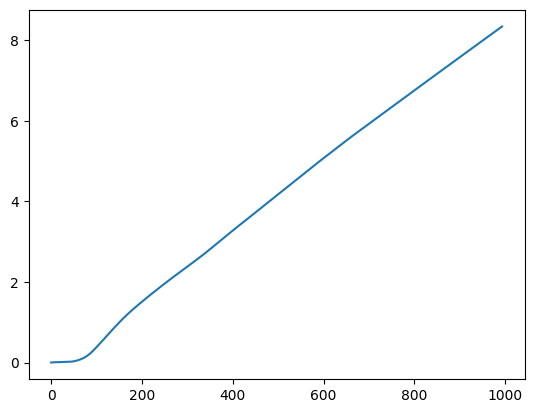

In [25]:

plt.plot(chamfer_dist)
plt.show()

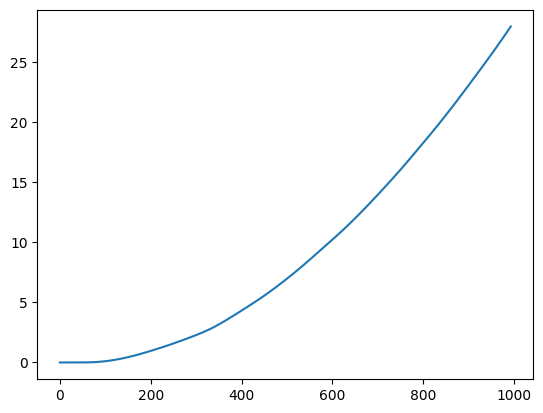

In [32]:
plt.plot(np.mean(( rollout_data['predicted_rollout'] - rollout_data['ground_truth_rollout'] ) ** 2, axis=1).sum(axis=1))

In [2]:
import meshio
import os
import torch
from torch_geometric.data import Data

# Get list of mesh files
mesh_files = [f for f in os.listdir('vtk') if f.endswith('.vtk')]

# Load with meshio and print stats
for mesh_file in sorted(mesh_files):
    mesh = meshio.read('vtk/' + mesh_file)
    xy_coordinates = mesh.points[:, :2].astype('float32').newbyteorder('=')
    positions = torch.tensor(xy_coordinates, dtype=torch.float)
    print(positions)

    # Save as pytorch geometric data
    # pos = torch.tensor(mesh.points, dtype=torch.float)
    # faces = torch.tensor(mesh.cells['triangle'], dtype=torch.long)
    # data = Data(pos=pos, face=faces)
    # torch.save(data, '../data/' + mesh_file + '.pt')

{}
tensor([[-1.9250,  0.1261],
        [-1.9250,  0.1748],
        [-1.9250,  0.2248],
        ...,
        [-0.6250,  0.0748],
        [-0.5250,  0.0748],
        [-0.5750,  0.0748]])
{}
tensor([[-1.9242,  0.0969],
        [-1.9500,  0.1337],
        [-1.9412,  0.1663],
        ...,
        [ 0.1018,  0.0478],
        [ 0.4987,  0.0388],
        [ 0.2232,  0.0452]])
{}
tensor([[-1.6572,  0.3793],
        [-0.6954,  0.2770],
        [-1.5407,  0.2692],
        ...,
        [-0.0462,  0.0498],
        [-0.0875,  0.0498],
        [-0.3046,  0.1426]])
{}
tensor([[-1.6577,  0.3685],
        [-0.6647,  0.2689],
        [-1.5341,  0.2648],
        ...,
        [-0.0064,  0.0497],
        [-0.0487,  0.0500],
        [-0.2603,  0.1405]])
{}
tensor([[-1.6589,  0.3589],
        [-0.6345,  0.2607],
        [-1.5292,  0.2612],
        ...,
        [ 0.0337,  0.0498],
        [-0.0086,  0.0501],
        [-0.2148,  0.1386]])
{}
tensor([[0.1822, 0.1671],
        [0.2014, 0.1112],
        [0.2259, 0.1

In [71]:
data_dir='vtk'
mesh_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.vtk')])
all_positions = []

for mesh_file in mesh_files:
    mesh = meshio.read(os.path.join(data_dir, mesh_file))
    xy_coordinates = mesh.points[:, :2].astype('float32')
    positions = torch.tensor(xy_coordinates, dtype=torch.float)
    all_positions.append(positions)

vel_mean = 0
for frame in range(len(all_positions)):
    vel_mean += torch.mean(all_positions[frame])
vel_mean /= len(all_positions)


In [56]:
import json
with open('data.json', 'w') as f:
    json.dump(data, f)

with open('metadata.json', 'w') as f:
    f.write('test')

In [3]:
import os
import meshio
import torch
from torch_geometric.data import Data, Dataset

def generate_metadata(dataset):
    # Initialize accumulators for velocity and acceleration sums
    metadata = {}
    # Assuming 2 dimensions (x and y)
    total_vel_sum = torch.zeros(2)  
    total_acc_sum = torch.zeros(2)  
    total_vel_count = 0
    total_acc_count = 0

    # For standard deviation calculations
    vel_list_x = []
    vel_list_y = []
    acc_list_x = []
    acc_list_y = []

    # Iterate over the dataset
    for features, labels in dataset:
        vel_sequence = features[:, 1:] - features[:, :-1]
        acc_sequence = vel_sequence[:, 1:] - vel_sequence[:, :-1]
        
        # Calculate means
        total_vel_sum += torch.sum(vel_sequence, dim=(0, 1))
        total_acc_sum += torch.sum(acc_sequence, dim=(0, 1))
        total_vel_count += vel_sequence.numel()  # Only count the values in the velocity sequence
        total_acc_count += acc_sequence.numel()
        
        # Store velocity and acceleration sequences for standard deviation calculation
        vel_list_x.append(vel_sequence[:, 0].reshape(-1))  # Flatten x dimension to 1D tensor for std calculation
        vel_list_y.append(vel_sequence[:, 1].reshape(-1))  # Flatten y dimension to 1D tensor for std calculation
        acc_list_x.append(acc_sequence[:, 0].reshape(-1))  # Flatten x dimension to 1D tensor for std calculation
        acc_list_y.append(acc_sequence[:, 1].reshape(-1))  # Flatten y dimension to 1D tensor for std calculation

    # Compute means
    mean_velocity = np.float64(total_vel_sum / total_vel_count)
    mean_acceleration = np.float64(total_acc_sum / total_acc_count)

    # Calculate standard deviations
    vel_tensor = torch.stack([torch.cat(vel_list_x), torch.cat(vel_list_y)])
    acc_tensor = torch.stack([torch.cat(acc_list_x), torch.cat(acc_list_y)])


    std_velocity = np.float64(torch.std(vel_tensor, dim=1, unbiased=False))
    std_acceleration = np.float64(torch.std(acc_tensor, dim=1, unbiased=False))

    metadata['vel_mean'] = list(mean_velocity)
    metadata['acc_mean'] = list(mean_acceleration)
    metadata['vel_std'] = list(std_velocity)
    metadata['acc_std'] = list(std_acceleration)
    metadata['bounds'] = [[-2.0, 2.0], [0.0, 4.0]]
    metadata['sequence_length'] = len(dataset)
    metadata['default_connectivity_radius'] = 0.05
    metadata['dim'] = 2
    metadata['dt'] = 0.0025

    import json
    with open('new_metadata.json', 'w') as f:
        json.dump(metadata, f)


class SimulationDataset(Dataset):
    def __init__(
            self, 
            device='cuda',
            data_dir='vtk', 
            window_size=6
        ):
        super().__init__()
        self.device = device
        self.data_windows, self.labels, self.n_particles_per_example = self.prepare_data(data_dir, window_size)


    def load_mesh_files(self, data_dir):
        mesh_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.vtk')])
        all_positions = []
        for mesh_file in mesh_files:
            mesh = meshio.read(os.path.join(data_dir, mesh_file))
            xy_coordinates = mesh.points[:, :2].astype('float32')
            positions = torch.tensor(xy_coordinates, dtype=torch.float)
            all_positions.append(positions)
        return all_positions

    def create_sliding_windows(self, positions_list, window_size):
        data_windows = []
        labels = []
        n_particles_per_example = []
        num_frames = len(positions_list)
        for i in range(num_frames - window_size):
            window = positions_list[i:i+window_size]
            label = positions_list[i+window_size]
            data_windows.append(torch.stack(window).to(self.device))
            labels.append(label.to(self.device))
            # Get number of particles (first dimension of positions tensor)
            num_particles = len(window[0])
            n_particles_per_example.append(torch.tensor([num_particles]).to(self.device))
        return data_windows, labels, n_particles_per_example

    def prepare_data(self, data_dir, window_size):
        positions_list = self.load_mesh_files(data_dir)
        data_windows, labels, n_particles_per_example = self.create_sliding_windows(positions_list, window_size)
        return data_windows, labels, n_particles_per_example

    def __len__(self):
        return len(self.data_windows)
    
    def __getitem__(self, idx):
        data_window = self.data_windows[idx].permute(1,0,2)
        label = self.labels[idx]
        n_particles = self.n_particles_per_example[idx]
        return data_window, label #, n_particles

# Usage
ds = SimulationDataset(device=device, window_size=6)
generate_metadata(ds)


max_c = 1
c = 0
for features, labels in ds:
    print(features.shape)
    particle_types = torch.full((features.shape[0],), 5)
    print(particle_types.shape)

    c += 1
    if c == max_c:
        break


torch.Size([841, 6, 2])
torch.Size([841])


In [9]:
from learned_simulator import Simulator
from model_utils import get_random_walk_noise_for_position_sequence

simulator = Simulator(
        particle_dimension=2,
        node_in=30,
        edge_in=3,
        latent_dim=128,
        num_message_passing_steps=10,
        mlp_num_layers=2,
        mlp_hidden_dim=128,
        connectivity_radius=metadata['default_connectivity_radius'],
        boundaries=np.array(metadata['bounds']),
        normalization_stats=normalization_stats,
        num_particle_types=9,
        particle_type_embedding_size=16,
        strategy='baseline',
        device=device,
    )


step = 0
running_loss = 0.0
for features, labels in ds:
    # features['position'] = torch.tensor(features['position']).to(device)
    # features['n_particles_per_example'] = torch.tensor(features['n_particles_per_example']).to(device)
    # features['particle_type'] = torch.tensor(features['particle_type']).to(device)
    # labels = torch.tensor(labels).to(device)
    particle_types = torch.full((features.shape[0],), 5).to(device)

    sampled_noise = get_random_walk_noise_for_position_sequence(features, noise_std_last_step=noise_std).to(device)
    non_kinematic_mask = (particle_types != 3).clone().detach().to(device)
    sampled_noise *= non_kinematic_mask.reshape(-1, 1, 1)
    print(sampled_noise.shape)
    pred, target = simulator.get_predicted_and_target_normalized_accelerations(
        next_position=labels, 
        position_sequence_noise=sampled_noise, 
        position_sequence=features, 
        n_particles_per_example=None,#features['n_particles_per_example'], 
        particle_types=particle_types,
    )
    loss = (pred - target) ** 2
    loss = loss.sum(dim=-1)
    num_non_kinematic = non_kinematic_mask.sum()    

    loss = torch.where(non_kinematic_mask.bool(), loss, torch.zeros_like(loss))
    loss = loss.sum() / num_non_kinematic

    # if step % log_steps == 0:
    #     writer.add_scalar('training_loss', loss, step)
    #     writer.add_scalar('lr', lr_new, step)

    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    
    print(loss)
    break
    

AttributeError: 'dict' object has no attribute 'shape'

In [5]:
import torch
from tf_data_reader import prepare_data_from_tfds
from learned_simulator import Simulator
from model_utils import get_random_walk_noise_for_position_sequence

ds = prepare_data_from_tfds(data_path='data/', batch_size=2)


simulator = Simulator(
        particle_dimension=2,
        node_in=30,
        edge_in=3,
        latent_dim=128,
        num_message_passing_steps=10,
        mlp_num_layers=2,
        mlp_hidden_dim=128,
        connectivity_radius=metadata['default_connectivity_radius'],
        boundaries=np.array(metadata['bounds']),
        normalization_stats=normalization_stats,
        num_particle_types=9,
        particle_type_embedding_size=16,
        strategy='mc',
        device=device,
    )

{'particle_type': <tf.Tensor 'args_0:0' shape=(None,) dtype=int64>, 'position': <tf.Tensor 'strided_slice_1:0' shape=(None, 6, 2) dtype=float32>, 'n_particles_per_example': <tf.Tensor 'strided_slice_3:0' shape=(1,) dtype=int32>}


In [8]:
max_c = 1
c = 0
for features, labels in ds:
    features['position'] = torch.tensor(features['position']).to(device)
    features['n_particles_per_example'] = torch.tensor(features['n_particles_per_example']).to(device)
    features['particle_type'] = torch.tensor(features['particle_type']).to(device)
    labels = torch.tensor(labels).to(device)

    sampled_noise = get_random_walk_noise_for_position_sequence(features['position'], noise_std_last_step=noise_std).to(device)
    non_kinematic_mask = (features['particle_type'] != 3).clone().detach().to(device)
    sampled_noise *= non_kinematic_mask.view(-1, 1, 1)
    print(sampled_noise.shape)
    print(features['n_particles_per_example'].shape)
    print(features['particle_type'].shape)

    pred, target = simulator.get_predicted_and_target_normalized_accelerations(
        next_position=labels, 
        position_sequence_noise=sampled_noise, 
        position_sequence=features['position'], 
        n_particles_per_example=features['n_particles_per_example'], 
        particle_types=features['particle_type'],
    )
    print(pred.shape)
    break


    

tensor([5])
torch.Size([1356, 6, 2])
torch.Size([2])
torch.Size([1356])
shape of x_i:  torch.Size([10108, 128])
shape of x_j:  torch.Size([10108, 128])
shape of edge_features:  torch.Size([10108, 128])
shape of edge_features after cat:  torch.Size([10108, 384])
shape of edge_features after NN:  torch.Size([10108, 128])
shape of x_i:  torch.Size([10108, 128])
shape of x_j:  torch.Size([10108, 128])
shape of edge_features:  torch.Size([10108, 128])
shape of edge_features after cat:  torch.Size([10108, 384])
shape of edge_features after NN:  torch.Size([10108, 128])
shape of x_i:  torch.Size([10108, 128])
shape of x_j:  torch.Size([10108, 128])
shape of edge_features:  torch.Size([10108, 128])
shape of edge_features after cat:  torch.Size([10108, 384])
shape of edge_features after NN:  torch.Size([10108, 128])
shape of x_i:  torch.Size([10108, 128])
shape of x_j:  torch.Size([10108, 128])
shape of edge_features:  torch.Size([10108, 128])
shape of edge_features after cat:  torch.Size([1010

2024-08-18 09:46:18.866796: W tensorflow/core/framework/dataset.cc:959] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [2]:
for element in ds:
    n_particles_per_example = element[0]['n_particles_per_example']
    print(element[0].keys())
    print(element[0]['position'].shape)
    print(element[1].shape)
    print(n_particles_per_example)

    break

TypeError: 'NoneType' object is not iterable

In [ ]:
def split_trajectory()